![Cloud-First](https://github.com/tulip-lab/sit742/blob/develop/Jupyter/image/CloudFirst.png?raw=1)


# SIT742: Modern Data Science
**(Module: Big Data Manipulation)**

---
- Materials in this module include resources collected from various open-source online repositories.
- You are free to use, change and distribute this package.
- If you found any issue/bug for this document, please submit an issue at [tulip-lab/sit742](https://github.com/tulip-lab/sit742/issues)


Prepared by **SIT742 Teaching Team**

---



## Session 4F: A Touch of Apache Spark
---

This lab session will teach you how to use [Apache Spark](http://spark.apache.org/), a framework for large-scale data processing, within a notebook.

You may need to do the following before running this notebook in Cloud platform such as Google Colab, DataBricks, or IBM Cloud:
- Create one cluster to run your tasks and the following lab sessions
- Install the necessary packages such as
 * matplotlib
 * test_helper
 * pyzmq
 * pandas
 * hashlib
- Import all related lab sessions into Workspace
- Import all needed data into Tables or S3, and note down the address of each file.


### Content

Part A: Apache Spark

* [PySpark](#pyspark)

* [RDD Transformations and Actions](#rdd)

* [Lambda functions](#lambda)

* [Additional RDD actions](#actions)

* [Additional RDD transformations](#transfoormations)

* [Caching RDDs and storage options](#cache)

* [Debugging Spark applications and lazy evaluation](#debug)

Part B: Test Spark functionality

* [Check Spark Functionality](#spark)

* [Check class Testing Functionality](#test)

* [Check Plotting](#plot)
---


## Introduction ##

Many traditional frameworks were designed to be run on a single computer. However, many datasets today are too large to be stored on a single computer, and even when a dataset can be stored on one computer (such as the datasets in this tutorial), the dataset can often be processed much more quickly using multiple computers.  Spark has efficient implementations of a number of transformations and actions that can be composed together to perform data processing and analysis.  Spark excels at distributing these operations across a cluster while abstracting away many of the underlying implementation details. Spark has been designed with a focus on scalability and efficiency. With Spark you can begin developing your solution on your laptop, using a small dataset, and then use that same code to process terabytes or even petabytes across a distributed cluster.

The following transformations will be covered:
*  `map()`, `mapPartitions()`, `mapPartitionsWithIndex()`, `filter()`, `flatMap()`, `sortByKey()`, `reduceByKey()`, `groupByKey()`, `Join()`, `leftOuterJoin()`, `rightOuterJoin()`, `fullOuterJoin()`

The following actions will be covered:
*  `first()`, `take()`, `takeSample()`, `takeOrdered()`, `collect()`, `count()`, `countByValue()`, `reduce()`, `fold()`, `aggregate()`, `top()`

Also covered:
*  `cache()`, `unpersist()`, `id()`, `setName()`

Note that, for reference, you can look up the details of these methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/reference/pyspark.html)

After that you will test that the virtual machine (VM) is functioning properly.

You will not need to solve any problems to complete this lab.  You can run a cell by pressing "shift-enter", which will compute the current cell and advance to the next cell, or by clicking in a cell and pressing "control-enter", which will compute the current cell and remain in that cell.  

## Part A: Apache Spark ##


###  **1. Spark Context**

In Spark, communication occurs between a driver and executors.  The driver has Spark jobs that it needs to run and these jobs are split into tasks that are submitted to the executors for completion.  The results from these tasks are delivered back to the driver.

In section 1, we saw that normal python code can be executed via cells. When using Databricks Cloud this code gets executed in the Spark driver's Java Virtual Machine (JVM) and not in an executor's JVM, and when using an IPython notebook it is executed within the kernel associated with the notebook. Since no Spark functionality is actually being used, no tasks are launched on the executors.

In order to use Spark functionality and its API we will need to use a `SparkContext`.  When running Spark, you start a new Spark application by creating a [SparkContext](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.SparkContext.html).  When the `SparkContext` is created, it asks the master for some cores to use to do work.  The master sets these cores aside just for you; they won't be used for other applications. When using Databricks Cloud or the virtual machine provisioned for this class, the `SparkContext` is created for you automatically as `sc`.

###  **2. [pySpark API](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.html) running in the browser**



#### **(2a) Example Cluster**

The diagram below shows an example cluster, where the cores allocated for an application are outlined in purple.
![executors](http://spark-mooc.github.io/web-assets/images/executors.png)

At a high level, every Spark application consists of a driver program that launches various parallel operations on executor Java Virtual Machines (JVMs) running either in a cluster or locally on the same machine. When running a cluster, such as ...In Databricks Cloud, "Databricks Shell" is the driver program.  When running locally, "PySparkShell" is the driver program. In all cases, this driver program contains the main loop for the program and creates distributed datasets on the cluster, then applies operations (transformations & actions) to those datasets.

Driver programs access Spark through a SparkContext object, which represents a connection to a computing cluster. A Spark context object (`sc`) is the main entry point for Spark functionality. A Spark context can be used to create Resilient Distributed Datasets (RDDs) on a cluster.

**Note**: It is important for you to change the path/URL of the latest Spark package, so that it is working with latest Spark release.

In [1]:
#update local version of the package catalog
!apt-get update

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,628 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,940 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,197 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [12

In [2]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
# unzip it
!tar xf spark-3.4.0-bin-hadoop3.tgz

In [4]:
# install findspark
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

import findspark
findspark.init()

In [5]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

##### ** Predefined Variables**


Notebooks already have some of the most useful Apache Spark variables that you’re going to need:

- sc
- sqlContext



In [6]:
# A SQLContext is also already created for you.
# Do not create another or unspecified behavior may occur.
# As you can see below, the sqlContext provided is a HiveContext.
#For the difference between the HiveContext and sqlContext, please refer the URL
#https://stackoverflow.com/questions/33666545/what-is-the-difference-between-apache-spark-sqlcontext-vs-hivecontext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
sqlContext

/content/spark-3.4.0-bin-hadoop3/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [7]:
# A Spark Context is already created for you.
# Do not create another or unspecified behavior may occur.
#The sc command will show SparkContext Infomation including the Version, Master name and APP
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [8]:
# Run this to check Spark Context sc is already loded
# Display the type of the Spark Context sc
print("The sc type is ",type(sc),"\nThe sqlContext type is ",type(sqlContext))


The sc type is  <class 'pyspark.context.SparkContext'> 
The sqlContext type is  <class 'pyspark.sql.context.SQLContext'>


#### **(2b) `SparkContext` attributes**

You can use Python's [dir()](https://docs.python.org/2/library/functions.html?highlight=dir#dir) function to get a list of all the attributes (including methods) accessible through the `sc` object.

In [9]:
# List sc's attributes
dir(sc)

['PACKAGE_EXTENSIONS',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getnewargs__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_accumulatorServer',
 '_active_spark_context',
 '_assert_on_driver',
 '_batchSize',
 '_callsite',
 '_checkpointFile',
 '_conf',
 '_dictToJavaMap',
 '_do_init',
 '_encryption_enabled',
 '_ensure_initialized',
 '_gateway',
 '_getJavaStorageLevel',
 '_initialize_context',
 '_javaAccumulator',
 '_jsc',
 '_jvm',
 '_lock',
 '_next_accum_id',
 '_pickled_broadcast_vars',
 '_python_includes',
 '_repr_html_',
 '_serialize_to_jvm',
 '_temp_dir',
 '_unbatched_serializer',
 'accumulator',
 'addArchive',
 'addFile',
 'addPyFile',


#### **(2c) Getting help**

Alternatively, you can use Python's [help()](https://docs.python.org/2/library/functions.html?highlight=help#help) function to get an easier to read list of all the attributes, including examples, that the `sc` object has.

In [10]:
# Use help to obtain more detailed information
#Please note tha xrange() is replaced by the range() in Python 3
help(sc)

Help on SparkContext in module pyspark.context object:

class SparkContext(builtins.object)
 |  SparkContext(master: Optional[str] = None, appName: Optional[str] = None, sparkHome: Optional[str] = None, pyFiles: Optional[List[str]] = None, environment: Optional[Dict[str, Any]] = None, batchSize: int = 0, serializer: 'Serializer' = CloudPickleSerializer(), conf: Optional[pyspark.conf.SparkConf] = None, gateway: Optional[py4j.java_gateway.JavaGateway] = None, jsc: Optional[py4j.java_gateway.JavaObject] = None, profiler_cls: Type[pyspark.profiler.BasicProfiler] = <class 'pyspark.profiler.BasicProfiler'>, udf_profiler_cls: Type[pyspark.profiler.UDFBasicProfiler] = <class 'pyspark.profiler.UDFBasicProfiler'>, memory_profiler_cls: Type[pyspark.profiler.MemoryProfiler] = <class 'pyspark.profiler.MemoryProfiler'>)
 |
 |  Main entry point for Spark functionality. A SparkContext represents the
 |  connection to a Spark cluster, and can be used to create :class:`RDD` and
 |  broadcast variables o

In [11]:
# After reading the help we've decided we want to use sc.version to see what version of Spark we are running
sc.version

'3.4.0'

In [12]:
# Help can be used on any Python object
help(map)

Help on class map in module builtins:

class map(object)
 |  map(func, *iterables) --> map object
 |
 |  Make an iterator that computes the function using arguments from
 |  each of the iterables.  Stops when the shortest iterable is exhausted.
 |
 |  Methods defined here:
 |
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |
 |  __iter__(self, /)
 |      Implement iter(self).
 |
 |  __next__(self, /)
 |      Implement next(self).
 |
 |  __reduce__(...)
 |      Return state information for pickling.
 |
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |
 |  __new__(*args, **kwargs)
 |      Create and return a new object.  See help(type) for accurate signature.



<a id = "rdd"></a>

### **3. Using RDDs and chaining together transformations and actions**

#### **Working with your first RDD**

In Spark, we first create a base [Resilient Distributed Dataset](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.html) (RDD). We can then apply one or more transformations to that base RDD. *An RDD is immutable, so once it is created, it cannot be changed.* As a result, each transformation creates a new RDD. Finally, we can apply one or more actions to the RDDs.  Note that Spark uses lazy evaluation, so transformations are not actually executed until an action occurs.

We will perform several exercises to obtain a better understanding of RDDs:
*   Create a Python collection of 10,000 integers
*   Create a Spark base RDD from that collection
*   Subtract one from each value using `map`
*   Perform action `collect` to view results
*   Perform action `count` to view counts
*   Apply transformation `filter` and view results with `collect`
*   Learn about lambda functions
*   Explore how lazy evaluation works and the debugging challenges that it introduces

#### **(3a) Create a Python collection of integers in the range of 1 .. 10000**

In python 3, the xrang() is removed. We will use the [range()](https://docs.python.org/3.8/library/functions.html?highlight=xrange#func-range) function to create a  constructor to represent an immutable sequence of numbers.  `

In [13]:
data = range(1, 10001)

In [14]:
# Data is just a normal Python list
# Obtain data's first element
data[0]

1

In [15]:
# We can check the size of the list using the len() function
len(data)

10000

#### **(3b) Distributed data and using a collection to create an RDD**

In Spark, datasets are represented as a list of entries, where the list is broken up into many different partitions that are each stored on a different machine.  Each partition holds a unique subset of the entries in the list.  Spark calls datasets that it stores "Resilient Distributed Datasets" (RDDs).

One of the defining features of Spark, compared to other data analytics frameworks (e.g., Hadoop), is that it stores data in memory rather than on disk.  This allows Spark applications to run much more quickly, because they are not slowed down by needing to read data from disk.

The figure below illustrates how Spark breaks a list of data entries into partitions that are each stored in memory on a worker.
![partitions](http://spark-mooc.github.io/web-assets/images/partitions.png)

To create the RDD, we use `sc.parallelize()`, which tells Spark to create a new set of input data based on data that is passed in.  In this example, we will provide an `range`.  The second argument to the [sc.parallelize()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.SparkContext.parallelize.html) method tells Spark how many partitions to break the data into when it stores the data in memory (we'll talk more about this later in this tutorial). Note that for better performance when using `parallelize`, `range()` is recommended if the input represents a range. This is the reason why we used `range()` in 3a.

There are many different types of RDDs.  The base class for RDDs is [pyspark.RDD](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.html) and other RDDs subclass `pyspark.RDD`.  Since the other RDD types inherit from `pyspark.RDD` they have the same APIs and are functionally identical.  We'll see that `sc.parallelize()` generates a `pyspark.rdd.PipelinedRDD` when its input is an `range`, and a `pyspark.RDD` when its input is a `range`.

After we generate RDDs, we can view them in the "Storage" tab of the web UI.  You'll notice that new datasets are not listed until Spark needs to return a result due to an action being executed.  This feature of Spark is called "lazy evaluation".  This allows Spark to avoid performing unnecessary calculations.

In [16]:
# Parallelize data including 10000 using 8 partitions
# This operation is a transformation of data into an RDD
# Spark uses lazy evaluation, so no Spark jobs are run at this point
rangeRDD = sc.parallelize(data, 8)

In [17]:
# Let's view help on parallelize
help(sc.parallelize)

Help on method parallelize in module pyspark.context:

parallelize(c: Iterable[~T], numSlices: Optional[int] = None) -> pyspark.rdd.RDD[~T] method of pyspark.context.SparkContext instance
    Distribute a local Python collection to form an RDD. Using range
    is recommended if the input represents a range for performance.

    .. versionadded:: 0.7.0

    Parameters
    ----------
    c : :class:`collections.abc.Iterable`
        iterable collection to distribute
    numSlices : int, optional
        the number of partitions of the new RDD

    Returns
    -------
    :class:`RDD`
        RDD representing distributed collection.

    Examples
    --------
    >>> sc.parallelize([0, 2, 3, 4, 6], 5).glom().collect()
    [[0], [2], [3], [4], [6]]
    >>> sc.parallelize(range(0, 6, 2), 5).glom().collect()
    [[], [0], [], [2], [4]]

    Deal with a list of strings.

    >>> strings = ["a", "b", "c"]
    >>> sc.parallelize(strings, 2).glom().collect()
    [['a'], ['b', 'c']]



In [18]:
# Let's see what type sc.parallelize() returned
print ('type of rangeRDD: {0}'.format(type(rangeRDD)))

type of rangeRDD: <class 'pyspark.rdd.PipelinedRDD'>


In [19]:
# Each RDD gets a unique ID
print ('rangeRDD id: {0}'.format(rangeRDD.id()))

rangeRDD id: 1


In [20]:
# We can name each newly created RDD using the setName() method
rangeRDD.setName('My first RDD')

My first RDD PythonRDD[1] at RDD at PythonRDD.scala:53

In [21]:
# Let's view the lineage (the set of transformations) of the RDD using toDebugString()
print (rangeRDD.toDebugString())

b'(8) My first RDD PythonRDD[1] at RDD at PythonRDD.scala:53 []\n |  ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:287 []'


In [22]:
# Let's use help to see what methods we can call on this RDD
help(rangeRDD)

Help on PipelinedRDD in module pyspark.rdd object:

class PipelinedRDD(RDD, typing.Generic)
 |  PipelinedRDD(prev: pyspark.rdd.RDD[~T], func: Callable[[int, Iterable[~T]], Iterable[~U]], preservesPartitioning: bool = False, isFromBarrier: bool = False)
 |
 |  Examples
 |  --------
 |  Pipelined maps:
 |
 |  >>> rdd = sc.parallelize([1, 2, 3, 4])
 |  >>> rdd.map(lambda x: 2 * x).cache().map(lambda x: 2 * x).collect()
 |  [4, 8, 12, 16]
 |  >>> rdd.map(lambda x: 2 * x).map(lambda x: 2 * x).collect()
 |  [4, 8, 12, 16]
 |
 |  Pipelined reduces:
 |
 |  >>> from operator import add
 |  >>> rdd.map(lambda x: 2 * x).reduce(add)
 |  20
 |  >>> rdd.flatMap(lambda x: [x, x]).reduce(add)
 |  20
 |
 |  Method resolution order:
 |      PipelinedRDD
 |      RDD
 |      typing.Generic
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, prev: pyspark.rdd.RDD[~T], func: Callable[[int, Iterable[~T]], Iterable[~U]], preservesPartitioning: bool = False, isFromBarrier: bool = False)


In [23]:

# Let's see how many partitions the RDD will be split into by using the getNumPartitions()rangeRDD.getNumPartitions()
print(rangeRDD.getNumPartitions())

8


#### **(3c): Subtract one from each value using `map`**

So far, we've created a distributed dataset that is split into many partitions, where each partition is stored on a single machine in our cluster.  Let's look at what happens when we do a basic operation on the dataset.  Many useful data analysis operations can be specified as "do something to each item in the dataset".  These data-parallel operations are convenient because each item in the dataset can be processed individually: the operation on one entry doesn't effect the operations on any of the other entries.  Therefore, Spark can parallelize the operation.

`map(f)`, the most common Spark transformation, is one such example: it applies a function `f` to each item in the dataset, and outputs the resulting dataset.  When you run `map()` on a dataset, a single *stage* of tasks is launched.  A *stage* is a group of tasks that all perform the same computation, but on different input data.  One task is launched for each partitition, as shown in the example below.  A task is a unit of execution that runs on a single machine. When we run `map(f)` within a partition, a new *task* applies `f` to all of the entries in a particular partition, and outputs a new partition. In this example figure, the dataset is broken into four partitions, so four `map()` tasks are launched.
![tasks](http://spark-mooc.github.io/web-assets/images/tasks.png)

The figure below shows how this would work on the smaller data set from the earlier figures.  Note that one task is launched for each partition.
![foo](http://spark-mooc.github.io/web-assets/images/map.png)

When applying the `map()` transformation, each item in the parent RDD will map to one element in the new RDD. So, if the parent RDD has twenty elements, the new RDD will also have twenty items.

Now we will use `map()` to subtract one from each value in the base RDD we just created. First, we define a Python function called `sub()` that will subtract one from the input integer. Second, we will pass each item in the base RDD into a `map()` transformation that applies the `sub()` function to each element. And finally, we print out the RDD transformation hierarchy using `toDebugString()`.

In [24]:
# Create sub function to subtract 1
def sub(value):
    """"Subtracts one from `value`.

    Args:
       value (int): A number.

    Returns:
        int: `value` minus one.
    """
    return (value - 1)

# Transform rangeRDD through map transformation using sub function
# Because map is a transformation and Spark uses lazy evaluation, no jobs, stages,
# or tasks will be launched when we run this code.
subRDD = rangeRDD.map(sub)

# Let's see the RDD transformation hierarchy
print (subRDD.toDebugString())

b'(8) PythonRDD[2] at RDD at PythonRDD.scala:53 []\n |  ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:287 []'


#### ** (3d) Perform action `collect` to view results **

To see a list of elements decremented by one, we need to create a new list on the driver from the the data distributed in the executor nodes.  To do this we call the `collect()` method on our RDD.  `collect()` is often used after a filter or other operation to ensure that we are only returning a *small* amount of data to the driver.  This is done because the data returned to the driver must fit into the driver's available memory.  If not, the driver will crash.

The `collect()` method is the first action operation that we have encountered.  Action operations cause Spark to perform the (lazy) transformation operations that are required to compute the RDD returned by the action.  In our example, this means that tasks will now be launched to perform the `parallelize`, `map`, and `collect` operations.

In this example, the dataset is broken into four partitions, so four `collect()` tasks are launched. Each task collects the entries in its partition and sends the result to the SparkContext, which creates a list of the values, as shown in the figure below.
![collect](http://spark-mooc.github.io/web-assets/images/collect.png)

The above figures showed what would happen if we ran `collect()` on a small example dataset with just four partitions.

Now let's run `collect()` on `subRDD`.

In [25]:
# Let's collect the data
print (subRDD.collect())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

#### ** (3d) Perform action `count` to view counts **

One of the most basic jobs that we can run is the `count()` job which will count the number of elements in an RDD using the `count()` action. Since `map()` creates a new RDD with the same number of elements as the starting RDD, we expect that applying `count()` to each RDD will return the same result.

Note that because `count()` is an action operation, if we had not already performed an action with `collect()`, then Spark would now perform the transformation operations when we executed `count()`.

Each task counts the entries in its partition and sends the result to your SparkContext, which adds up all of the counts. The figure below shows what would happen if we ran `count()` on a small example dataset with just four partitions.
![count](http://spark-mooc.github.io/web-assets/images/count.png)

In [26]:
print (rangeRDD.count())
print (subRDD.count())

10000
10000


#### ** (3e) Apply transformation `filter` and view results with `collect` **

Next, we'll create a new RDD that only contains the values less than ten by using the `filter(f)` data-parallel operation. The `filter(f)` method is a transformation operation that creates a new RDD from the input RDD by applying filter function `f` to each item in the parent RDD and only passing those elements where the filter function returns `True`. Elements that do not return `True` will be dropped. Like `map()`, filter can be applied individually to each entry in the dataset, so is easily parallelized using Spark.

The figure below shows how this would work on the small four-partition dataset.
![filter](http://spark-mooc.github.io/web-assets/images/filter.png)

To filter this dataset, we'll define a function called `ten()`, which returns `True` if the input is less than 10 and `False` otherwise.  This function will be passed to the `filter()` transformation as the filter function `f`.

To view the filtered list of elements less than ten, we need to create a new list on the driver from the distributed data on the executor nodes.  We use the `collect()` method to return a list that contains all of the elements in this filtered RDD to the driver program.

In [27]:
# Define a function to filter a single value
def ten(value):
    """Return whether value is below ten.

    Args:
        value (int): A number.

    Returns:
        bool: Whether `value` is less than ten.
    """
    if (value < 10):
        return True
    else:
        return False
# The ten function could also be written concisely as: def ten(value): return value < 10

# Pass the function ten to the filter transformation
# Filter is a transformation so no tasks are run
filteredRDD = subRDD.filter(ten)

# View the results using collect()
# Collect is an action and triggers the filter transformation to run
print (filteredRDD.collect())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [28]:
def number(value):
    if (value > 10):
        return True
    else:
        return False

In [29]:
filterlessRDD = subRDD.filter(number)
print (filteredRDD)
print (filterlessRDD.collect())

PythonRDD[5] at collect at /tmp/ipython-input-552825945.py:23
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 2

<a id = "lambda"></a>

### ** 4. Lambda Functions **

#### ** (4a) Using Python `lambda()` functions **

Python supports the use of small one-line anonymous functions that are not bound to a name at runtime. Borrowed from LISP, these `lambda` functions can be used wherever function objects are required. They are syntactically restricted to a single expression. Remember that `lambda` functions are a matter of style and using them is never required - semantically, they are just syntactic sugar for a normal function definition. You can always define a separate normal function instead, but using a `lambda()` function is an equivalent and more compact form of coding. Ideally you should consider using `lambda` functions where you want to encapsulate non-reusable code without littering your code with one-line functions.

Here, instead of defining a separate function for the `filter()` transformation, we will use an inline `lambda()` function.

In [30]:
lambdaRDD = subRDD.filter(lambda x: x < 10)
lambdaRDD.collect()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [31]:
# Let's collect the even values less than 10
evenRDD = lambdaRDD.filter(lambda x: x % 2 == 0)
evenRDD.collect()

[0, 2, 4, 6, 8]

<a id = "actions"></a>

### ** 5. Additional RDD actions **

#### ** (5a) Other common actions **

Let's investigate the additional actions: [first()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.first.html), [take()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.take.html), [top()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.top.html), [takeOrdered()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.takeOrdered.html ), and [reduce()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.reduce.html)

One useful thing to do when we have a new dataset is to look at the first few entries to obtain a rough idea of what information is available.  In Spark, we can do that using the `first()`, `take()`, `top()`, and `takeOrdered()` actions. Note that for the `first()` and `take()` actions, the elements that are returned depend on how the RDD is *partitioned*.

Instead of using the `collect()` action, we can use the `take(n)` action to return the first n elements of the RDD. The `first()` action returns the first element of an RDD, and is equivalent to `take(1)`.

The `takeOrdered()` action returns the first n elements of the RDD, using either their natural order or a custom comparator. The key advantage of using `takeOrdered()` instead of `first()` or `take()` is that `takeOrdered()` returns a deterministic result, while the other two actions may return differing results, depending on the number of partions or execution environment. `takeOrdered()` returns the list sorted in *ascending order*.  The `top()` action is similar to `takeOrdered()` except that it returns the list in *descending order.*

The `reduce()` action reduces the elements of a RDD to a single value by applying a function that takes two parameters and returns a single value.  The function should be commutative and associative, as `reduce()` is applied at the partition level and then again to aggregate results from partitions.  If these rules don't hold, the results from `reduce()` will be inconsistent.  Reducing locally at partitions makes `reduce()` very efficient.

In [32]:
# Let's get the first element
print (filteredRDD.first())
# The first 4
print (filteredRDD.take(4))
# Note that it is ok to take more elements than the RDD has
print (filteredRDD.take(12))

0
[0, 1, 2, 3]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [33]:
# Retrieve the three smallest elements
print (filteredRDD.takeOrdered(3))
# Retrieve the five largest elements
print (filteredRDD.top(5))

[0, 1, 2]
[9, 8, 7, 6, 5]


In [34]:
# Pass a lambda function to takeOrdered to reverse the order
filteredRDD.takeOrdered(4, lambda s: -s)

[9, 8, 7, 6]

In [35]:
# Obtain Python's add function
from operator import add
# Efficiently sum the RDD using reduce
print (filteredRDD.reduce(add))
# Sum using reduce with a lambda function
print (filteredRDD.reduce(lambda a, b: a + b))
# Note that subtraction is not both associative and commutative
print (filteredRDD.reduce(lambda a, b: a - b))
print (filteredRDD.repartition(4).reduce(lambda a, b: a - b))
# While addition is
print (filteredRDD.repartition(4).reduce(lambda a, b: a + b))

45
45
-45
-45
45


#### ** (5b) Advanced actions **

Here are two additional actions that are useful for retrieving information from an RDD: [takeSample()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.takeSample.html) and [countByValue()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.countByValue.html)

The `takeSample()` action returns an array with a random sample of elements from the dataset.  It takes in a `withReplacement` argument, which specifies whether it is okay to randomly pick the same item multiple times from the parent RDD (so when `withReplacement=True`, you can get the same item back multiple times). It also takes an optional `seed` parameter that allows you to specify a seed value for the random number generator, so that reproducible results can be obtained.

The `countByValue()` action returns the count of each unique value in the RDD as a dictionary that maps values to counts.

In [36]:
# takeSample reusing elements
print (filteredRDD.takeSample(withReplacement=True, num=6))
# takeSample without reuse
print (filteredRDD.takeSample(withReplacement=False, num=6))

[3, 2, 2, 5, 5, 4]
[7, 2, 5, 9, 1, 8]


In [37]:
# Set seed for predictability
print (filteredRDD.takeSample(withReplacement=False, num=6, seed=500))
# Try reruning this cell and the cell above -- the results from this cell will remain constant
# Use ctrl-enter to run without moving to the next cell

[6, 4, 0, 1, 3, 5]


In [38]:
# Create new base RDD to show countByValue
repetitiveRDD = sc.parallelize([1, 2, 3, 1, 2, 3, 1, 2, 1, 2, 3, 3, 3, 4, 5, 4, 6])
print (repetitiveRDD.countByValue())

defaultdict(<class 'int'>, {1: 4, 2: 4, 3: 5, 4: 2, 5: 1, 6: 1})


<a id = "transformations"></a>

### ** 6. Additional RDD transformations **

#### ** (6a) `flatMap` **

When performing a `map()` transformation using a function, sometimes the function will return more (or less) than one element. We would like the newly created RDD to consist of the elements outputted by the function. Simply applying a `map()` transformation would yield a new RDD made up of iterators.  Each iterator could have zero or more elements.  Instead, we often want an RDD consisting of the values contained in those iterators.  The solution is to use a [flatMap()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.flatMap.html) transformation, `flatMap()` is similar to `map()`, except that with `flatMap()` each input item can be mapped to zero or more output elements.

To demonstrate `flatMap()`, we will first emit a word along with its plural, and then a range that grows in length with each subsequent operation.

In [39]:
# Let's create a new base RDD to work from
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)

# Use map
singularAndPluralWordsRDDMap = wordsRDD.map(lambda x: (x, x + 's'))
# Use flatMap
singularAndPluralWordsRDD = wordsRDD.flatMap(lambda x: (x, x + 's'))

# View the results
print (singularAndPluralWordsRDDMap.collect())
print (singularAndPluralWordsRDD.collect())
# View the number of elements in the RDD
print (singularAndPluralWordsRDDMap.count())
print (singularAndPluralWordsRDD.count())

[('cat', 'cats'), ('elephant', 'elephants'), ('rat', 'rats'), ('rat', 'rats'), ('cat', 'cats')]
['cat', 'cats', 'elephant', 'elephants', 'rat', 'rats', 'rat', 'rats', 'cat', 'cats']
5
10


In [40]:
simpleRDD = sc.parallelize([2, 3, 4])
print (simpleRDD.map(lambda x: range(1, x)).collect())
print (simpleRDD.flatMap(lambda x: range(1, x)).collect())

[range(1, 2), range(1, 3), range(1, 4)]
[1, 1, 2, 1, 2, 3]


#### ** (6b) `groupByKey` and `reduceByKey`  **

Let's investigate the additional transformations: [groupByKey()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.groupByKey.html) and [reduceByKey()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.reduceByKey.html).

Both of these transformations operate on pair RDDs.  A pair RDD is an RDD where each element is a pair tuple (key, value).  For example, `sc.parallelize([('a', 1), ('a', 2), ('b', 1)])` would create a pair RDD where the keys are 'a', 'a', 'b' and the values are 1, 2, 1.

The `reduceByKey()` transformation gathers together pairs that have the same key and applies a function to two associated values at a time. `reduceByKey()` operates by applying the function first within each partition on a per-key basis and then across the partitions.

While both the `groupByKey()` and `reduceByKey()` transformations can often be used to solve the same problem and will produce the same answer, the `reduceByKey()` transformation works much better for large distributed datasets. This is because Spark knows it can combine output with a common key on each partition *before* shuffling (redistributing) the data across nodes.  Only use `groupByKey()` if the operation would not benefit from reducing the data before the shuffle occurs.

Look at the diagram below to understand how `reduceByKey` works.  Notice how pairs on the same machine with the same key are combined (by using the lamdba function passed into reduceByKey) before the data is shuffled. Then the lamdba function is called again to reduce all the values from each partition to produce one final result.
![reduceByKey() figure](http://spark-mooc.github.io/web-assets/images/reduce_by.png)

On the other hand, when using the `groupByKey()` transformation - all the key-value pairs are shuffled around, causing a lot of unnecessary data to being transferred over the network.

To determine which machine to shuffle a pair to, Spark calls a partitioning function on the key of the pair. Spark spills data to disk when there is more data shuffled onto a single executor machine than can fit in memory. However, it flushes out the data to disk one key at a time, so if a single key has more key-value pairs than can fit in memory an out of memory exception occurs. This will be more gracefully handled in a later release of Spark so that the job can still proceed, but should still be avoided.  When Spark needs to spill to disk, performance is severely impacted.
![groupByKey() figure](http://spark-mooc.github.io/web-assets/images/group_by.png)

As your dataset grows, the difference in the amount of data that needs to be shuffled, between the `reduceByKey()` and `groupByKey()` transformations, becomes increasingly exaggerated.

Here are more transformations to prefer over `groupByKey()`:
  +   [combineByKey()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.combineByKey.html) can be used when you are combining elements but your return type differs from your input value type.
  +   [foldByKey()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.foldByKey.html ) merges the values for each key using an associative function and a neutral "zero value".

Now let's go through a simple `groupByKey()` and `reduceByKey()` example.

In [41]:
pairRDD = sc.parallelize([('a', 1), ('a', 2), ('b', 1)])
# mapValues only used to improve format for printing
print(pairRDD.groupByKey().mapValues(lambda x: list(x)).collect())

# Using mapValues, which is recommended when they key doesn't change
print(pairRDD.groupByKey().mapValues(lambda x: sum(x)).collect())

# reduceByKey is more efficient / scalable
print(pairRDD.reduceByKey(add).collect())

[('b', [1]), ('a', [1, 2])]
[('b', 1), ('a', 3)]
[('b', 1), ('a', 3)]


#### ** (6c)  `mapPartitions()` and  `mapPartitionsWithIndex()` ** [Optional]

Let's investigate the advanced transformations: [mapPartitions()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.mapPartitions.html) and [mapPartitionsWithIndex()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.mapPartitionsWithIndex.html)

The `mapPartitions()` transformation uses a function that takes in an iterator (to the items in that specific partition) and returns an iterator.  The function is applied on a partition by partition basis.

The `mapPartitionsWithIndex()` transformation uses a function that takes in a partition index (think of this like the partition number) and an iterator (to the items in that specific partition). For every partition (index, iterator) pair, the function returns a tuple of the same partition index number and an iterator of the transformed items in that partition.

In [42]:
# mapPartitions takes a function that takes an iterator and returns an iterator
print (wordsRDD.collect())
itemsRDD = wordsRDD.mapPartitions(lambda iterator: [','.join(iterator)])
print (itemsRDD.collect())

['cat', 'elephant', 'rat', 'rat', 'cat']
['cat', 'elephant', 'rat', 'rat,cat']


In [43]:
itemsByPartRDD = wordsRDD.mapPartitionsWithIndex(lambda index, iterator: [(index, list(iterator))])
# We can see that three of the (partitions) workers have one element and the fourth worker has two
# elements, although things may not bode well for the rat...
print (itemsByPartRDD.collect())
# Rerun without returning a list (acts more like flatMap)
itemsByPartRDD = wordsRDD.mapPartitionsWithIndex(lambda index, iterator: (index, list(iterator)))
print (itemsByPartRDD.collect())

[(0, ['cat']), (1, ['elephant']), (2, ['rat']), (3, ['rat', 'cat'])]
[0, ['cat'], 1, ['elephant'], 2, ['rat'], 3, ['rat', 'cat']]


#### ** (6d) Advanced transformations ** [Optional]

Let's investigate the additional transformations: [sortByKey()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.sortByKey.html), [join()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.join.html), [leftOuterJoin()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.leftOuterJoin.html), [rightOuterJoin()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.rightOuterJoin.html) and [fullOuterJoin()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.fullOuterJoin.html),

The `sortByKey()` returns a new dataset `(k,v)` pairs sorted by keys in ascending order.





In [44]:
rdd = sc.parallrdd2 = sc.parallelize([(1,'a'), (2,'c'), (1,'b')])
rdd.sortByKey().collect()

[(1, 'a'), (1, 'b'), (2, 'c')]

The `join()` is an inner join that returns RDD of all pairs of elements with matching keys in X and Y. Each pair is  `(k, (v1,v2)) ` tuple, where  `(k,v1) ` is in X, and  `(k,v2) ` is in Y.

Meanwhile, `leftOuterJoin()`, `rightOuterJoin()` and `fullOuterJoin()` perform outer join.    


*   `leftOuterJoin()`: For each element (k, v) in X, resulting RDD will either contain all pairs (k,(v, w)) for w in Y, Or pair (k,(v, None) if no elements in Y have key k.
*   `rightOuterJoin()`: For each element (k, w) in Y, resulting RDD will either contain all pairs (k,(v, w)) for v in X, Or pair (k,(None, w) if no elements in X have key k.
*   `fullOuterJoin()`: For each element (k,v) in X, resulting RDD will either contain all pairs (k,(v,w)) for w in Y, or (k,(v,None) if no match in Y have k; and For each element (k,w) in Y, resulting RDD with either contain all pairs (k,(v,w)) for v in X, or (k,(None,w) if no match in X have k.


In [45]:
# join()
x = sc.parallelize([("a", 1), ("b", 4)])
y = sc.parallelize([("a", 2), ("a", 3)])
sorted(x.join(y).collect())


[('a', (1, 2)), ('a', (1, 3))]

In [46]:
# leftOuterJoin()
x = sc.parallelize([("a", 1), ("b", 4)])
y = sc.parallelize([("a", 2)])
sorted(x.leftOuterJoin(y).collect())

[('a', (1, 2)), ('b', (4, None))]

In [47]:
# rightOuterJoin()
x = sc.parallelize([("a", 1), ("b", 4)])
y = sc.parallelize([("a", 2), ("c", 5)])
sorted(x.rightOuterJoin(y).collect())

[('a', (1, 2)), ('c', (None, 5))]

In [48]:
# fullOuterJoin()
x = sc.parallelize([("a", 1), ("b", 4)])
y = sc.parallelize([("a", 2), ("c", 5)])
sorted(x.fullOuterJoin(y).collect())

[('a', (1, 2)), ('b', (4, None)), ('c', (None, 5))]

### ** 7. Caching RDDs and storage options **

#### ** (7a) Caching RDDs **

For efficiency Spark keeps your RDDs in memory. By keeping the contents in memory, Spark can quickly access the data. However, memory is limited, so if you try to keep too many RDDs in memory, Spark will automatically delete RDDs from memory to make space for new RDDs. If you later refer to one of the RDDs, Spark will automatically recreate the RDD for you, but that takes time.

So, if you plan to use an RDD more than once, then you should tell Spark to cache that RDD. You can use the `cache()` operation to keep the RDD in memory. However, if you cache too many RDDs and Spark runs out of memory, it will delete the least recently used (LRU) RDD first. Again, the RDD will be automatically recreated when accessed.

You can check if an RDD is cached by using the `is_cached` attribute, and you can see your cached RDD in the "Storage" section of the Spark web UI. If you click on the RDD's name, you can see more information about where the RDD is stored.

In [49]:
# Name the RDD
filteredRDD.setName('My Filtered RDD')
# Cache the RDD
filteredRDD.cache()
# Is it cached
print (filteredRDD.is_cached)

True


#### ** (7b) Unpersist and storage options **

Spark automatically manages the RDDs cached in memory and will save them to disk if it runs out of memory. For efficiency, once you are finished using an RDD, you can optionally tell Spark to stop caching it in memory by using the RDD's `unpersist()` method to inform Spark that you no longer need the RDD in memory.

You can see the set of transformations that were applied to create an RDD by using the `toDebugString()` method, which will provide storage information, and you can directly query the current storage information for an RDD using the `getStorageLevel()` operation.

** Advanced: ** Spark provides many more options for managing how RDDs are stored in memory or even saved to disk. You can explore the API for RDD's [persist()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.persist.html) operation using Python's [help()](https://docs.python.org/2/library/functions.html?highlight=help#help) command.  The `persist()` operation, optionally, takes a pySpark [StorageLevel](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.StorageLevel.html) object.

In [50]:
# Note that toDebugString also provides storage information
print (filteredRDD.toDebugString())

b'(8) My Filtered RDD PythonRDD[5] at collect at /tmp/ipython-input-552825945.py:23 [Memory Serialized 1x Replicated]\n |  ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:287 [Memory Serialized 1x Replicated]'


In [51]:
# If we are done with the RDD we can unpersist it so that its memory can be reclaimed
filteredRDD.unpersist()
# Storage level for a non cached RDD
print (filteredRDD.getStorageLevel())
filteredRDD.cache()
# Storage level for a cached RDD
print (filteredRDD.getStorageLevel())

Serialized 1x Replicated
Memory Serialized 1x Replicated


<a id = "debug"></a>

### ** 8. Debugging Spark applications and lazy evaluation **

#### ** How Python is Executed in Spark **

Internally, Spark executes using a Java Virtual Machine (JVM). pySpark runs Python code in a JVM using [Py4J](http://py4j.sourceforge.net). Py4J enables Python programs running in a Python interpreter to dynamically access Java objects in a Java Virtual Machine. Methods are called as if the Java objects resided in the Python interpreter and Java collections can be accessed through standard Python collection methods. Py4J also enables Java programs to call back Python objects.

Because pySpark uses Py4J, coding errors often result in a complicated, confusing stack trace that can be difficult to understand. In the following section, we'll explore how to understand stack traces.

#### ** (8a) Challenges with lazy evaluation using transformations and actions **

Spark's use of lazy evaluation can make debugging more difficult because code is not always executed immediately. To see an example of how this can happen, let's first define a broken filter function.

Next we perform a `filter()` operation using the broken filtering function.  No error will occur at this point due to Spark's use of lazy evaluation.

The `filter()` method will not be executed *until* an action operation is invoked on the RDD.  We will perform an action by using the `collect()` method to return a list that contains all of the elements in this RDD.

In [52]:
def brokenTen(value):
    """Incorrect implementation of the ten function.

    Note:
        The `if` statement checks an undefined variable `val` instead of `value`.

    Args:
        value (int): A number.

    Returns:
        bool: Whether `value` is less than ten.

    Raises:
        NameError: The function references `val`, which is not available in the local or global
            namespace, so a `NameError` is raised.
    """
    if (val < 10):
        return True
    else:
        return False

brokenRDD = subRDD.filter(brokenTen)

In [54]:
# Now we'll see the error
brokenRDD.collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 60.0 failed 1 times, most recent failure: Lost task 1.0 in stage 60.0 (TID 281) (1172c520887d executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/content/spark-3.4.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 830, in main
    process()
  File "/content/spark-3.4.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 822, in process
    serializer.dump_stream(out_iter, outfile)
  File "/content/spark-3.4.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/spark-3.4.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3471806079.py", line 17, in brokenTen
NameError: name 'val' is not defined. Did you mean: 'eval'?

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1019)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2303)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1019)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1018)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor46.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/content/spark-3.4.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 830, in main
    process()
  File "/content/spark-3.4.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 822, in process
    serializer.dump_stream(out_iter, outfile)
  File "/content/spark-3.4.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/spark-3.4.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3471806079.py", line 17, in brokenTen
NameError: name 'val' is not defined. Did you mean: 'eval'?

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1019)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2303)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


#### ** (8b) Finding the bug **

When the `filter()` method is executed, Spark evaluates the RDD by executing the `parallelize()` and `filter()` methods. Since our `filter()` method has an error in the filtering function `brokenTen()`, an error occurs.

Scroll through the output "Py4JJavaError     Traceback (most recent call last)" part of the cell and first you will see that the line that generated the error is the `collect()` method line. There is *nothing wrong with this line*. However, it is an action and that caused other methods to be executed. Continue scrolling through the Traceback and you will see the following error line:
    NameError: global name 'val' is not defined

Looking at this error line, we can see that we used the wrong variable name in our filtering function `brokenTen()`.

#### ** (8c) Moving toward expert style **

As you are learning Spark, I recommend that you write your code in the form:
    RDD.transformation1()
    RDD.action1()
    RDD.transformation2()
    RDD.action2()

Using this style will make debugging your code much easier as it makes errors easier to localize - errors in your transformations will occur when the next action is executed.

Once you become more experienced with Spark, you can write your code with the form:
    RDD.transformation1().transformation2().action()

We can also use `lambda()` functions instead of separately defined functions when their use improves readability and conciseness.

In [55]:
# Cleaner code through lambda use
subRDD.filter(lambda x: x < 10).collect()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [56]:
# Even better by moving our chain of operators into a single line.
sc.parallelize(data).map(lambda y: y - 1).filter(lambda x: x < 10).collect()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#### ** (8d) Readability and code style **

To make the expert coding style more readable, enclose the statement in parentheses and put each method, transformation, or action on a separate line.

In [57]:
# Final version
(sc
 .parallelize(data)
 .map(lambda y: y - 1)
 .filter(lambda x: x < 10)
 .collect())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## **Part B: Test Spark functionality**

<a id = "spark"></a>

### 9. Spark Functionality

#### **(9a) Parallelize, filter, and reduce**

In [58]:
# Check that Spark is working
largeRange = sc.parallelize(range(100000))
reduceTest = largeRange.reduce(lambda a, b: a + b)
filterReduceTest = largeRange.filter(lambda x: x % 7 == 0).sum()

print (reduceTest)
print (filterReduceTest)

# If the Spark jobs don't work properly these will raise an AssertionError
assert reduceTest == 4999950000
assert filterReduceTest == 714264285

4999950000
714264285


#### **(9b) Loading a text file**

You can upload your file to Amazon S3 or other online storage so that the Spark cluster can access it.

In DataBricks, you can check this URL for information:

- https://docs.databricks.com/user-guide/advanced/filestore.html

You can import the data through Tables, Create Table, Data Import functions. Please remember to note down the prompt address, such as:

- /FileStore/tables/dnsmv70v1491290162600/shakespeare.txt

If the file uploading is properly done, you can access the file via Web browser using this URL:

- https://community.cloud.databricks.com/files/my-stuff/my-file.txt?o=######

Replace ###### with your community edition ID. Such as

- https://community.cloud.databricks.com/files/tables/dnsmv70v1491290162600/shakespeare.txt?o=48280648682457



In [59]:
# You can check the content of a specified folder on DataBricks' DBFS.
# display(dbutils.fs.ls("/FileStore/tables"))

NameError: name 'dbutils' is not defined

In [60]:
!pip install wget
import wget

link_to_data = 'https://raw.githubusercontent.com/tulip-lab/sit742/refs/heads/develop/Jupyter/data/shakespeare.txt'
DataSet = wget.download(link_to_data)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=2e1bb046aa75da8f4c43de09cd1c87852b1c7a0b8120981a5d66467f3b40e905
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [61]:
# Check loading data with sc.textFile
#import os.path
#baseDir = os.path.join('data')
#inputPath = os.path.join('cs100', 'lab1', 'shakespeare.txt')
#fileName = os.path.join(baseDir, inputPath)

# Replace this address by your own filestore address
rawData = sc.textFile('shakespeare.txt')
shakespeareCount = rawData.count()

print(shakespeareCount)

# If the text file didn't load properly an AssertionError will be raised
assert shakespeareCount == 122395

122395


<a id = "test"></a>

### **10. Check plotting**

#### **(10a) Our first plot**

After executing the code cell below, you should see a plot with 50 blue circles.  The circles should start at the bottom left and end at the top right.

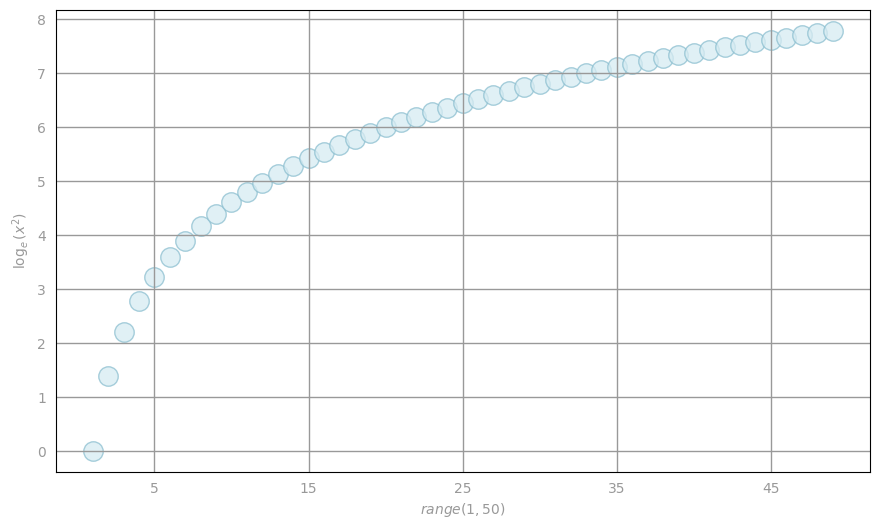

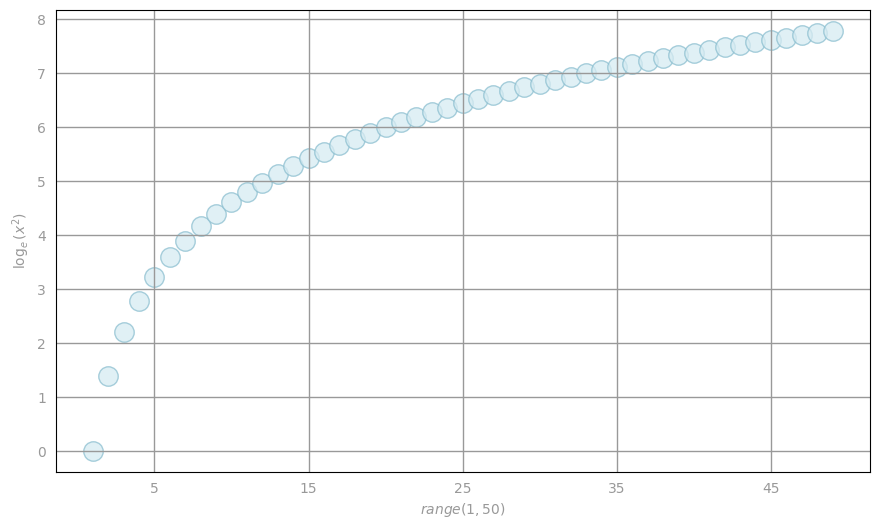

In [62]:
# Check matplotlib plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from math import log

# %matplotlib inline

# function for generating plot layout
def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999', gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot data
x = range(1, 50)
y = [log(x1 ** 2) for x1 in x]
fig, ax = preparePlot(range(5, 60, 10), range(0, 12, 1))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel(r'$range(1, 50)$'), ax.set_ylabel(r'$\log_e(x^2)$')

display(fig)
pass